# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:

In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32185879 entries, 0 to 32185878
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 982.2 MB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,3.218588e+07,3.218588e+07,3.218588e+07,3.218588e+07,3.218588e+07,3.218588e+07,3.218588e+07
mean,3.293647e+00,1.016442e+00,3.004604e-01,1.079199e+00,7.769151e-01,7.334443e-02,4.728664e-02
std,9.868834e+00,4.981302e+00,5.495389e-01,3.766374e+00,7.002098e-01,1.102101e+00,2.215802e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,2.863000e+04,1.398800e+04,6.730000e+02,9.939000e+03,2.368000e+03,3.390000e+03,1.320000e+02


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?

In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          32185879
n_isbns          17078096
n_loc_recs        9281535
n_ol_editions    25814159
n_ol_works       23754524
n_gr_books        1506465
n_gr_works        1505941
dtype: int64

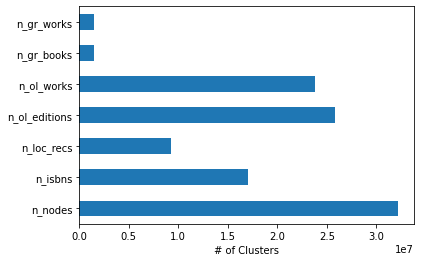

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.

In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,15107783
1,n_isbns,1,7697118
2,n_isbns,2,7466668
3,n_isbns,4,740195
4,n_isbns,3,579577


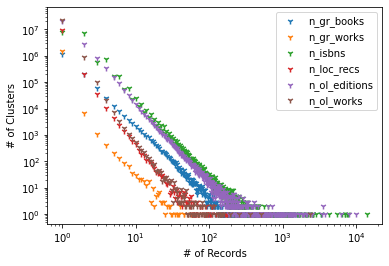

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8990 entries, 100026918 to 117956311
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        8990 non-null   uint32
 1   n_isbns        8990 non-null   uint32
 2   n_loc_recs     8990 non-null   uint32
 3   n_ol_editions  8990 non-null   uint32
 4   n_ol_works     8990 non-null   uint32
 5   n_gr_books     8990 non-null   uint32
 6   n_gr_works     8990 non-null   uint32
dtypes: uint32(7)
memory usage: 316.1 KB


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?

In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.0002793150375044907

Less than 1%. Not bad, but let's look.

In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100026918,28630,13988,673,9939,508,3390,132
100073294,17698,7166,494,8116,358,1476,88
100227025,6789,3292,192,2555,258,422,70
100122502,454,165,4,93,76,60,56
104486307,315,141,1,51,18,53,51


## Large Cluster Debugging

We have some pretty big clusters:

In [12]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100026918,28630,13988,673,9939,508,3390,132
100073294,17698,7166,494,8116,358,1476,88
100044980,15480,7681,186,6168,89,1333,23
102066477,11281,7520,0,3760,1,0,0
100063034,10902,5451,178,3484,145,1599,45


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?

In [13]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,LOC,GR,OL,BX,AZ14
isbn_id,,,,,,
1,0836932722,2,0,3,0,0
2,0965406334,1,0,1,0,0
3,0780363175,1,0,2,0,0
4,0780363590,1,0,2,0,0
5,0780363604,1,0,2,0,0


In [14]:
links = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
links.head()

,isbn_id,cluster
0,32715079,932715079
1,32715078,932715078
2,32715077,932715077
3,32715076,932715076
4,32715075,932715075


In [15]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].drop(columns=['cluster'])
bl = bl.join(isbns, on='isbn_id')
bl.sort_values('isbn')

,isbn_id,isbn,LOC,GR,OL,BX,AZ14
32682167,18776255,0001004735,0,0,1,0,0
32689491,14801858,0001848259,0,0,1,0,0
32687960,14658699,0001849123,0,0,1,0,0
32690625,17998580,0001956795,0,0,1,0,0
32679284,11209379,0003302245,0,0,1,0,0
...,...,...,...,...,...,...,...
32680857,16216287,9998392802,0,0,1,0,0
32679923,29068235,9998556643,0,0,1,0,0
32686428,12289218,9998651174,0,0,1,0,0
32690803,24146508,9998708710,0,0,1,0,0


What are the things with the highest record count (besides ratings)?

In [16]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn_id,isbn,LOC,GR,OL,BX,AZ14,btot
32680098,7878449,1559029838,0,1,14,180,0,15
32680099,10447012,9781559029834,0,0,11,0,0,11
32679663,871160,0394848284,3,0,7,2,4,10
32678105,4145077,9781402726019,3,1,4,0,0,8
32680069,4828587,9780192727992,1,1,6,0,0,8
32680321,7512124,1577595394,0,1,7,0,0,8
32684030,1395236,0716631970,4,0,4,0,0,8
32678101,4145078,1402726015,2,1,4,0,31,7
32680322,8661227,9781577595397,0,1,6,0,0,7
32683532,5108168,9780674035751,1,0,6,0,0,7
